Libraries

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
import mysql.connector
from sklearn import tree
import folium

Database Connection

In [53]:
db = mysql.connector.connect(
    host="localhost",
    user="user",
    password="password",
    port="3306",
    database="realestatepredictor"
)

Prepare data

In [54]:
# Create a cursor object
cursor = db.cursor()

# Execute the query
cursor.execute("SELECT * FROM homegate")

# Fetch all the records
data = cursor.fetchall()

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['id', 'homegateid', 'price', 'rooms', 'floor', 'livingSpace', 'street', 'latitude', 'longitude', 'locality', 'postalcode'])

# Close the cursor and connection
cursor.close()
db.close()

# Handle null / empty values
df = df.dropna()

# Handle outliers using IQR method for the price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
# df = df[~((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]
df = df[~(df['price'] < (Q1 - 1.5 * IQR))]

# Handle outliers using IQR method for the livingSpace
Q1 = df['livingSpace'].quantile(0.25)
Q3 = df['livingSpace'].quantile(0.75)
IQR = Q3 - Q1
# df = df[~((df['livingSpace'] < (Q1 - 1.5 * IQR)) | (df['livingSpace'] > (Q3 + 1.5 * IQR)))]
df = df[~(df['livingSpace'] < (Q1 - 1.5 * IQR))]

Descritive Statistics after removing outliers

In [55]:
print(df.describe())

               id         price       rooms       floor  livingSpace  \
count  107.000000  1.070000e+02  107.000000  107.000000   107.000000   
mean   693.728972  2.422307e+06    1.518692    2.579439    88.850467   
std     85.034352  9.417995e+05    0.205183    3.858432    68.369391   
min    553.000000  8.917500e+05    1.000000   -1.000000     9.000000   
25%    613.500000  1.838850e+06    1.500000    0.000000    17.500000   
50%    709.000000  2.275500e+06    1.500000    1.000000   120.000000   
75%    765.000000  2.822850e+06    1.500000    3.000000   140.000000   
max    824.000000  5.289000e+06    2.500000   20.000000   240.000000   

         latitude   longitude   postalcode  
count  107.000000  107.000000   107.000000  
mean    47.387497    8.537627  8040.943925  
std      0.022958    0.036926    17.600832  
min     47.342800    8.472870  8001.000000  
25%     47.361050    8.511865  8044.000000  
50%     47.389800    8.529970  8049.000000  
75%     47.409100    8.560020  8050.

Visualize Data

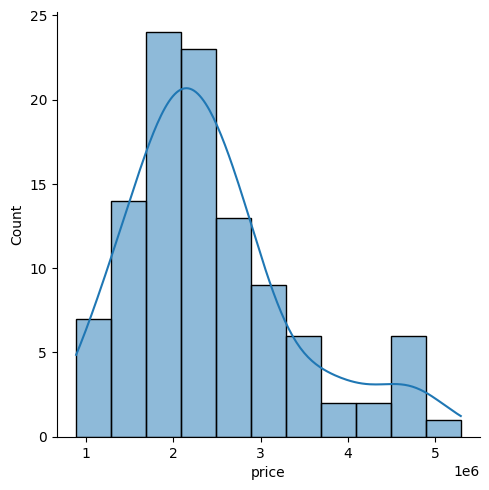

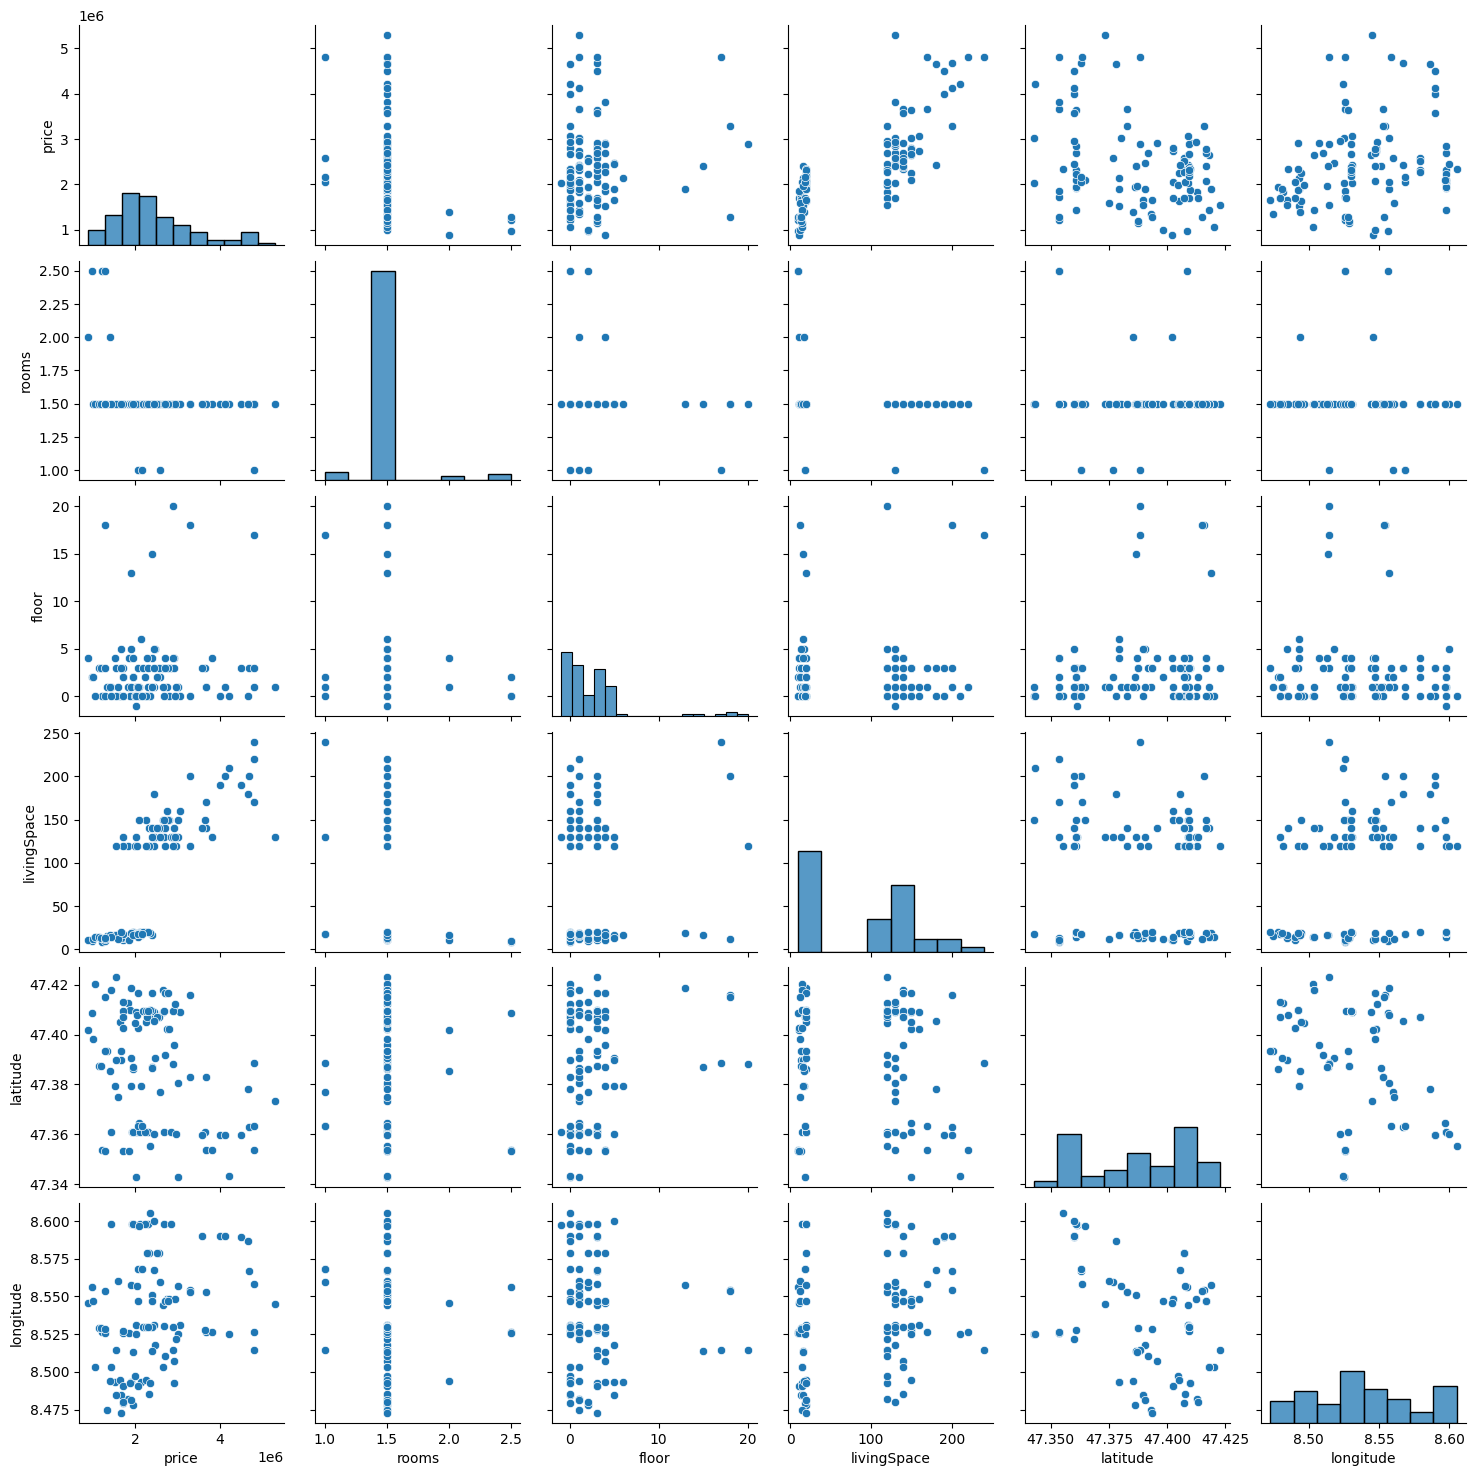

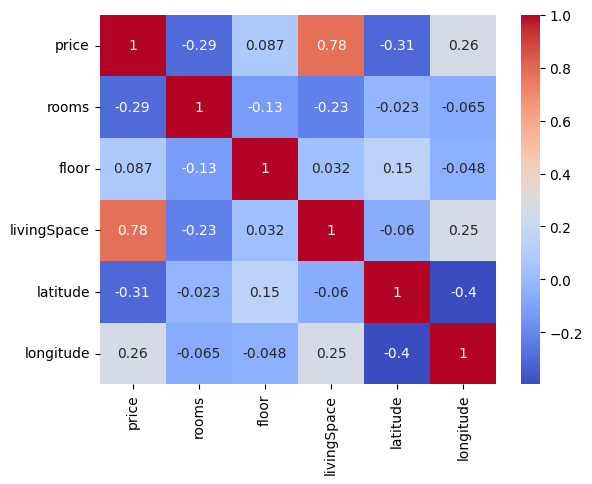

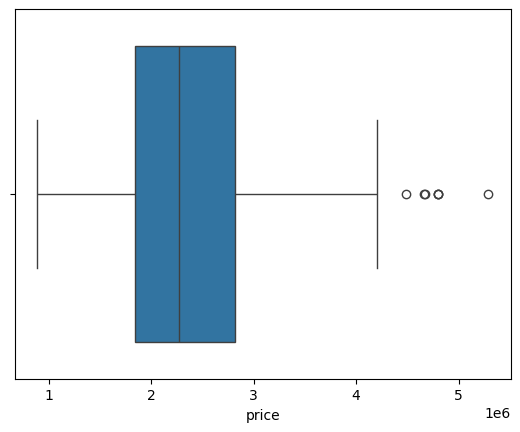

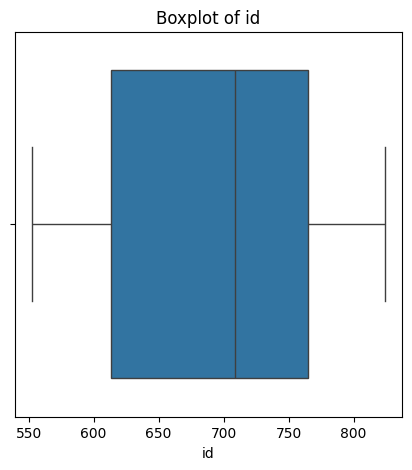

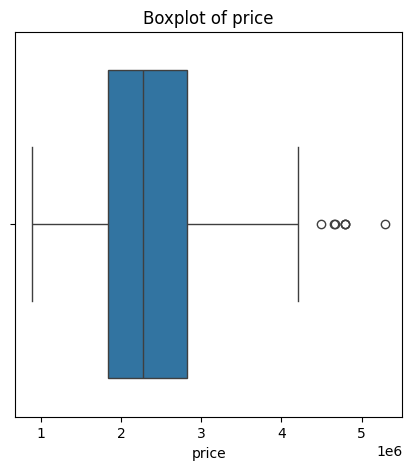

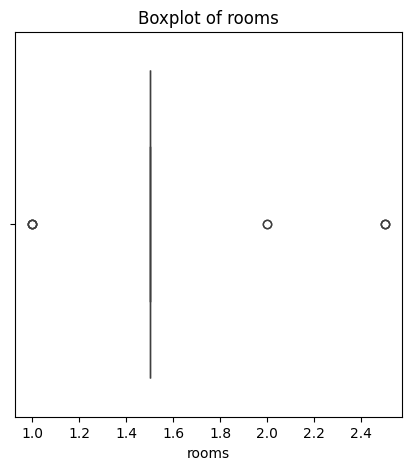

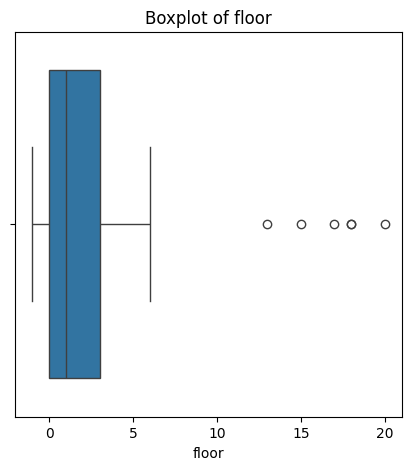

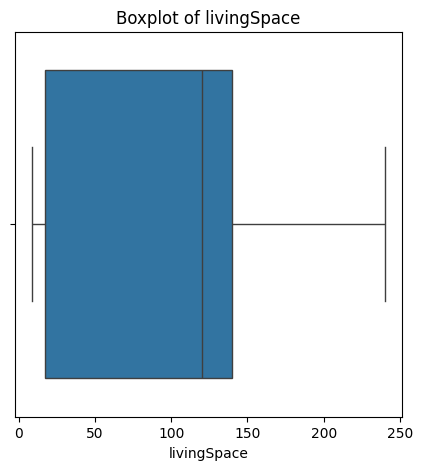

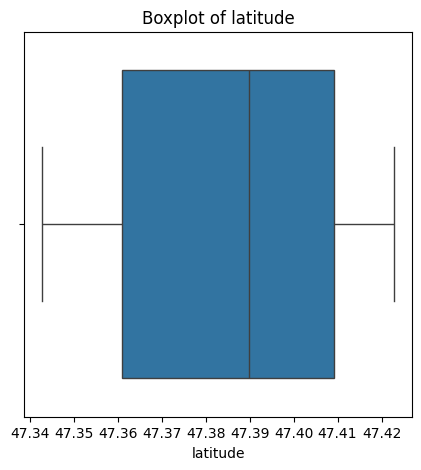

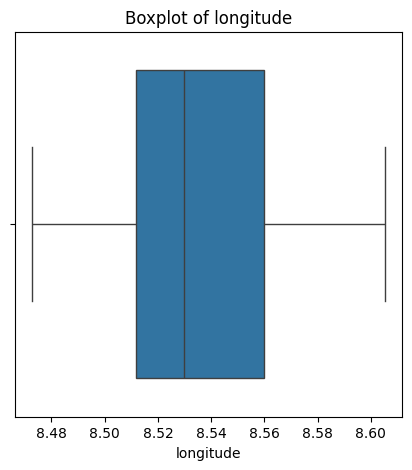

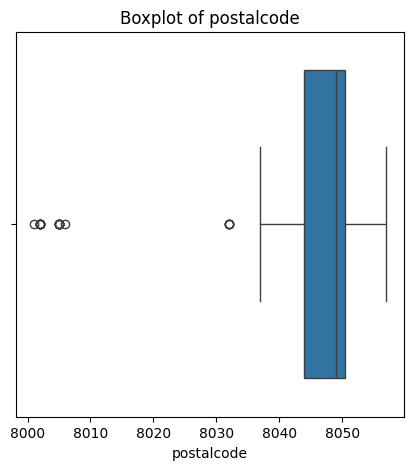

In [56]:
# Show the distribution of the different home prices
sns.displot(df['price'], kde=True)
plt.show()

# Show scatter plots to visualize the data
sns.pairplot(df[['price', 'rooms', 'floor', 'livingSpace', 'latitude', 'longitude']])
plt.show()

# Show a correlation heatmap
sns.heatmap(df[['price', 'rooms', 'floor', 'livingSpace', 'latitude', 'longitude']].corr(), annot=True, cmap='coolwarm')
plt.show()

# Visualize the boxplot for the price
sns.boxplot(x=df['price'])
plt.show()

# Visualize boxplots for all numeric columns
for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

GeoData Visualization

In [57]:
import folium

# Create a map centered around the mean latitude and longitude values
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=13)

# Add a marker for each home to the map
for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(m)

# Display the map
m

Random Forest

Root Mean Squared Error: 441499.13916020637


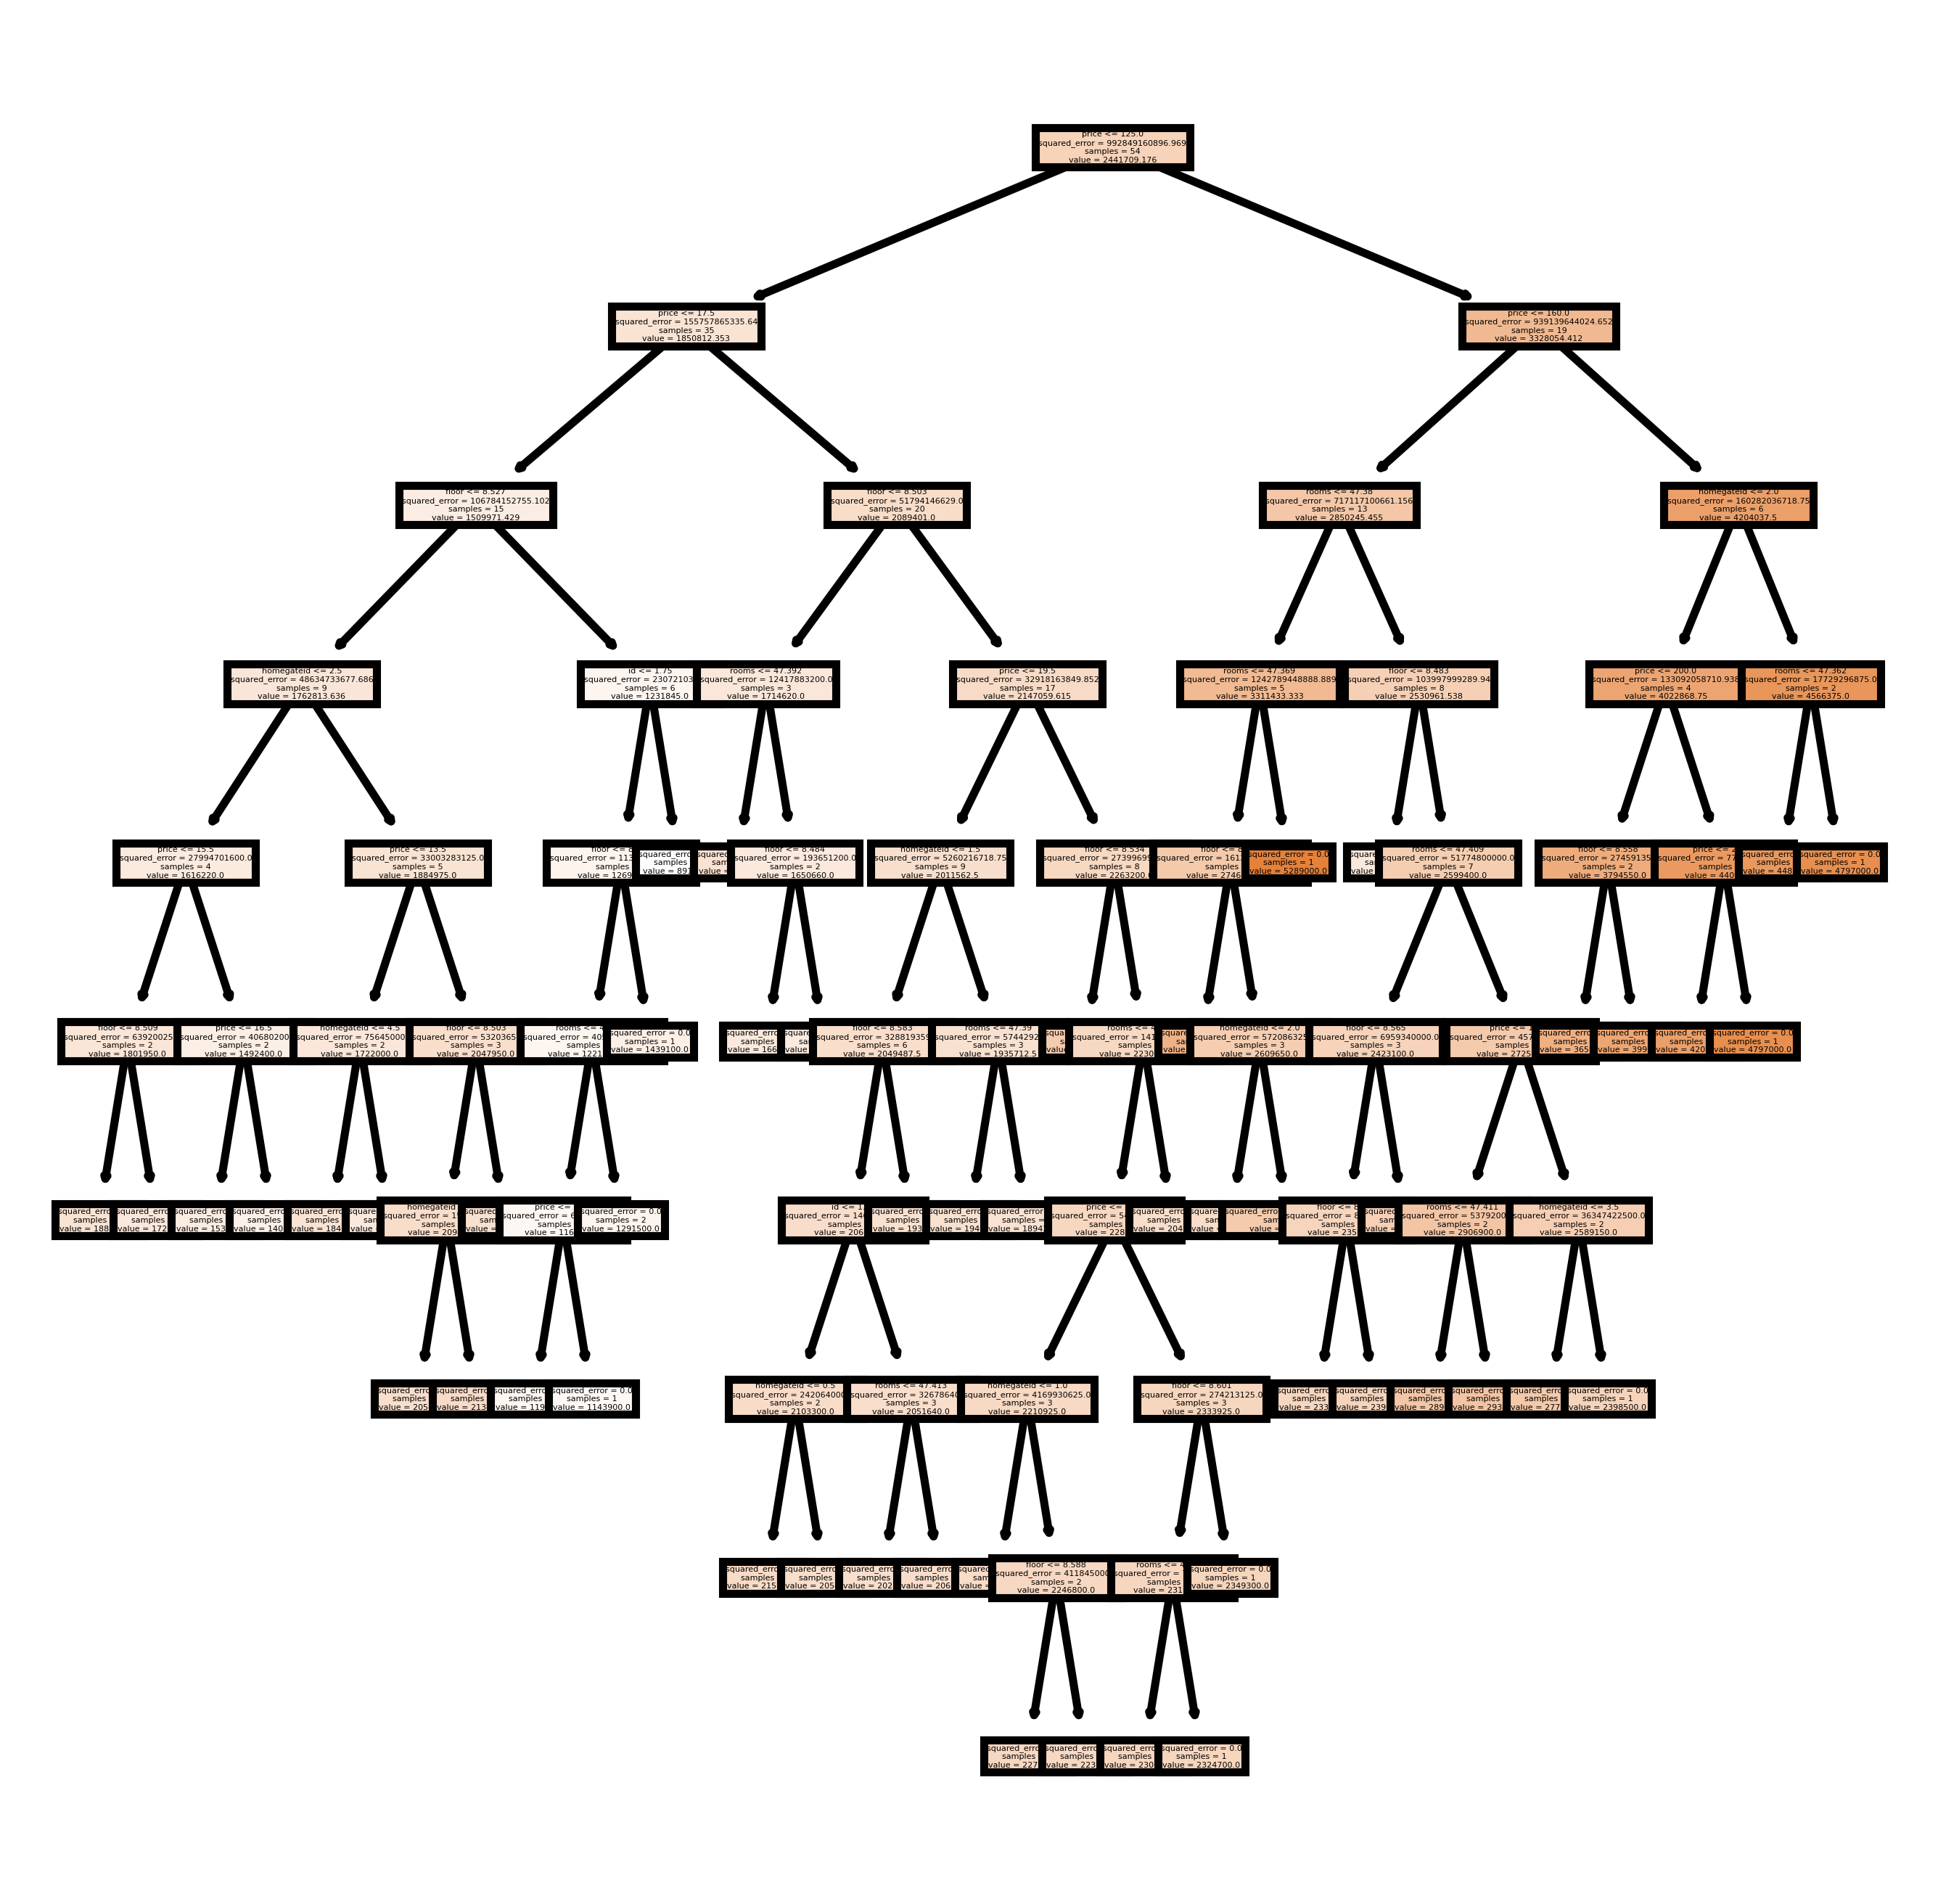

In [58]:
# Prepare the data for the random forest
X = df[['rooms', 'floor', 'livingSpace', 'latitude', 'longitude']]
y = df['price']

# Standardize the features. RMSE is slightly higher when using the scaled features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# Visualize
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 800)
tree.plot_tree(rf.estimators_[0], feature_names = df.columns, filled = True)
fig.savefig('rf_individualtree_1.png')

Random Forest, finding Hyperparameters automatically

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Root Mean Squared Error: 396720.5177881333


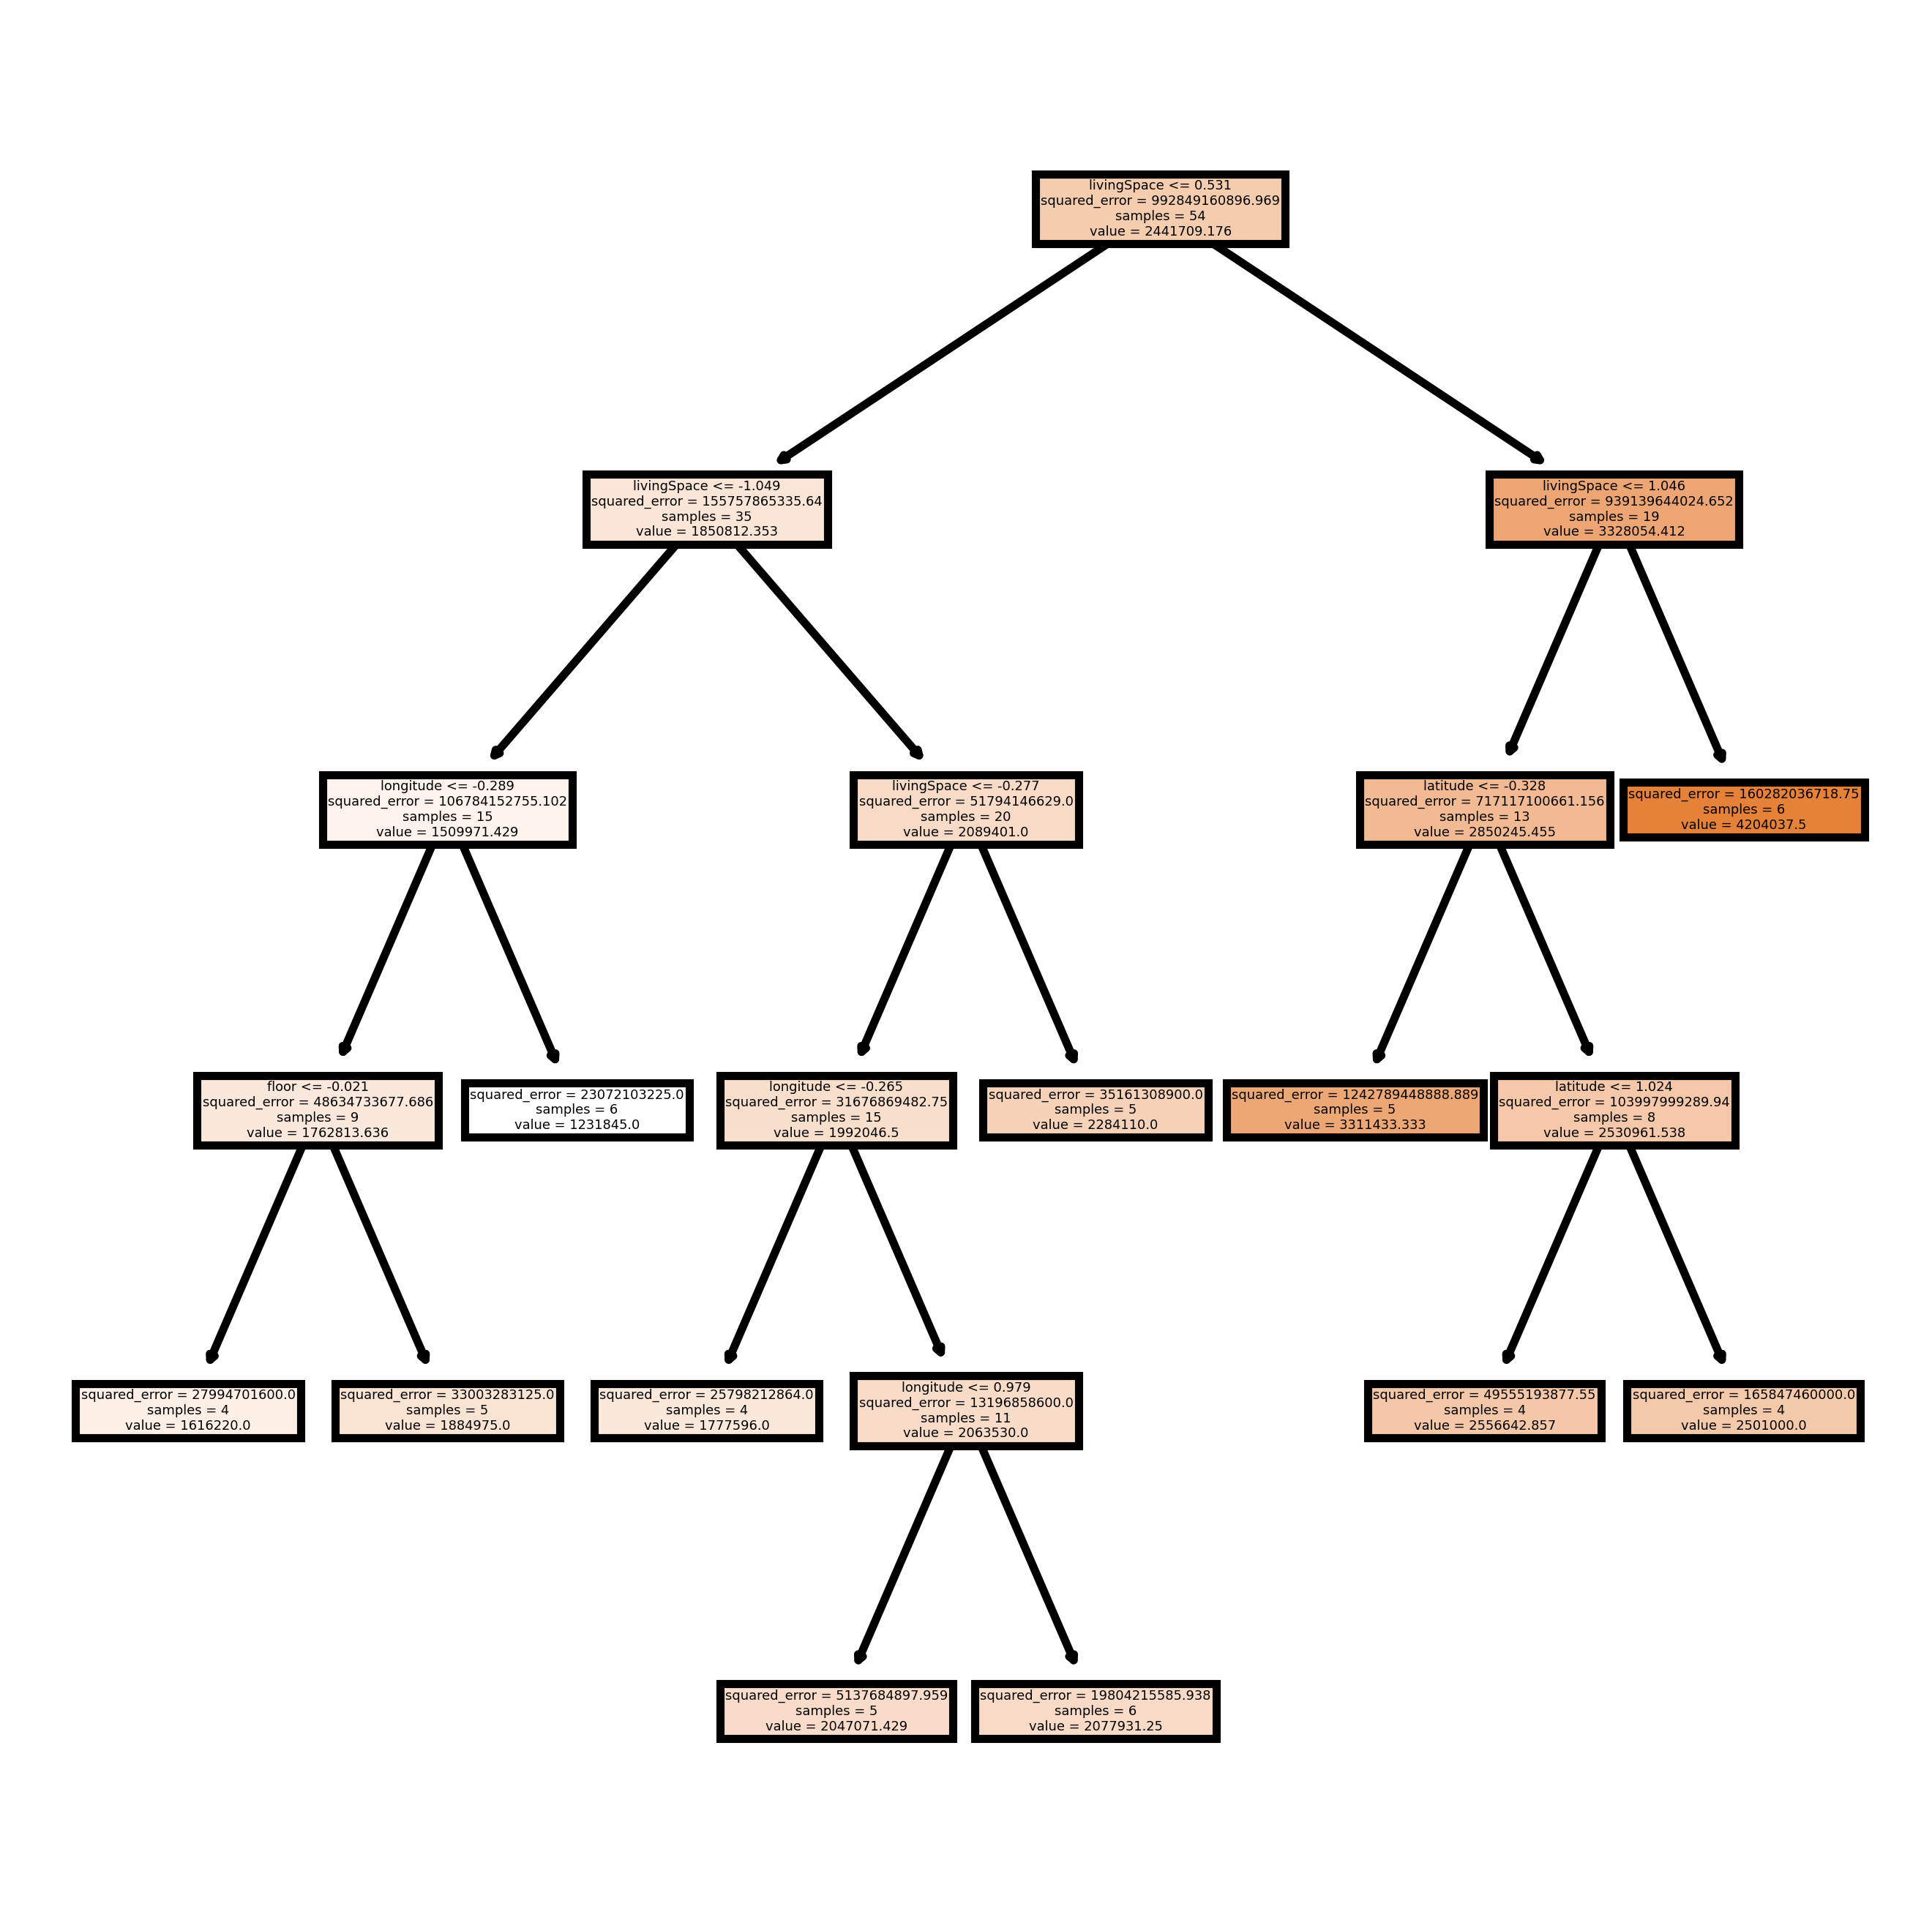

In [59]:
# Prepare the data for the random forest
X = df[['rooms', 'floor', 'livingSpace', 'latitude', 'longitude']]
y = df['price']

# Save column names before standardization
feature_names = X.columns

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the random forest
rf = RandomForestRegressor(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Train the model using the grid search estimator. 
# This will take the random forest model and try each combination of parameters
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Make predictions using the model with the best parameters
y_pred = grid_search.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 800)
tree.plot_tree(grid_search.best_estimator_.estimators_[0], feature_names = feature_names, filled = True)
fig.savefig('rf_individualtree_2.png')